In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import data_actions.data_processing.utils as utils
import seaborn as sns

# Data exploration for RecSys 2025

For the purpose of the efficiency and processing multiple datasets with millions of rows, we decided to use **Polars** instead of Pandas, because of its Lazy API, which enables us to better manage memory.


In [2]:
data_folder = "data/original_data"
data = utils.load_data(data_folder)


We also load relevant users from Numpy memmap as set, which allows us to do search operation in constant time.

In [3]:
relevant_users = set(data["inputs"]["relevant_clients"])

The timestamp column should be converted from string to datetime, as Polars is unable to convert it automatically while loading.

In [4]:
for key in data["events"]:
    data["events"][key] = utils.convert_timestamp_to_datetime(data["events"][key])
    


c:\Users\adams\VSC projects\RecSys2025\data_actions\data_processing\utils.py:64: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  if "timestamp" in df.columns:


At first, we want to examine general features of our dataset. Let's check out all the tables. We can see that dates range from 23rd May to 10th December of 2022. 

In the dataset, there are about:
- 1.7 million boughts
- 5.2 millions addings to cart
- 1.7 million removals from cart
- 150 millions page visits
- 9.6 millions search queries

In [ ]:
for df in data["events"]:
    print(f"{df}:")
    print(data["events"][df].describe())

add_to_cart:
shape: (9, 4)
┌────────────┬─────────────┬────────────────────────────┬───────────────┐
│ statistic  ┆ client_id   ┆ timestamp                  ┆ sku           │
│ ---        ┆ ---         ┆ ---                        ┆ ---           │
│ str        ┆ f64         ┆ str                        ┆ f64           │
╞════════════╪═════════════╪════════════════════════════╪═══════════════╡
│ count      ┆ 5.235882e6  ┆ 5235882                    ┆ 5.235882e6    │
│ null_count ┆ 0.0         ┆ 0                          ┆ 0.0           │
│ mean       ┆ 1.1941e7    ┆ 2022-08-06 03:13:35.597350 ┆ 748255.043147 │
│ std        ┆ 6.8914e6    ┆ null                       ┆ 433663.464805 │
│ min        ┆ 5.0         ┆ 2022-05-23 00:10:15        ┆ 0.0           │
│ 25%        ┆ 5.964675e6  ┆ 2022-07-01 19:22:20        ┆ 370909.0      │
│ 50%        ┆ 1.194213e7  ┆ 2022-08-08 22:15:45        ┆ 748335.0      │
│ 75%        ┆ 1.790411e7  ┆ 2022-09-12 10:08:30        ┆ 1.12609e6     │
│ max      

There is over 18 million users in the dataset.

In [5]:
clients = pl.concat([data["events"][df].select("client_id") for df in data["events"]])
unique_clients = clients.select(pl.col("client_id").unique())
print(f"Unique clients: {unique_clients.collect().height}")

Unique clients: 18889063


In [ ]:
def normalize_by_days_number(grouped_df, dataframe):
    days_df = (
        dataframe.with_columns(
            month=pl.col("timestamp").dt.month()
        )
        .group_by("month")
        .agg([
            pl.col("timestamp").dt.day().min().alias("min_day"),
            pl.col("timestamp").dt.day().max().alias("max_day")
        ])
        .with_columns(
            days = (pl.col("max_day") - pl.col("min_day") + 1)
        )
    )
    grouped_df = grouped_df.with_columns(
        month=pl.col("timestamp").dt.month()
    )
    grouped_df = (
        grouped_df.join(days_df, on="month", how="left")
                  .with_columns(
                      len = pl.col("len") / pl.col("days")
                  )
                  .drop(["month", "min_day", "max_day", "days"])
    )
    return grouped_df

def plot_time_histograms(normalize=True):
    sns.set_style("whitegrid")
    sns.set_palette("coolwarm")  
    
    fig, ax = plt.subplots(3, 2, figsize=(20, 12))
    fig.suptitle(
        "Number of events per day for every table" if normalize else "Number of events per month for every table",
        fontsize=16,
        fontweight="bold"
    )

    for i, key in enumerate(data["events"]):
        dataframe = data["events"][key].sort("timestamp")
        grouped_df = dataframe.group_by_dynamic("timestamp", every="1mo").agg(pl.len().alias("len"))
        
        if normalize:
            grouped_df = normalize_by_days_number(grouped_df, dataframe)
        
        grouped_df = grouped_df.collect()

        sns.barplot(
            x=grouped_df["timestamp"], 
            y=grouped_df["len"], 
            ax=ax[i // 2, i % 2], 
            color="royalblue"
        )

        ax[i // 2, i % 2].set_title(key, fontsize=14, fontweight="bold")
        ax[i // 2, i % 2].set_xlabel("Date", fontsize=12)
        ax[i // 2, i % 2].set_ylabel("Number of events", fontsize=12)
        ax[i // 2, i % 2].tick_params(axis="x", rotation=45)

    for j in range(i + 1, len(ax.flatten())):
        fig.delaxes(ax.flatten()[j])

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### Events per month 
Fortunately, there isn't much disproportion in the number of events per day between each month, but slight increase tendention should be noticed. When we look at numbers per month, much less value can be seen in May and October - that's because the dataset date range started at May 23rd and ended at October 10th.

What's interesting, page visits number per day don't increase through the time, which indicates that people view the same number of items, but buy more of them.

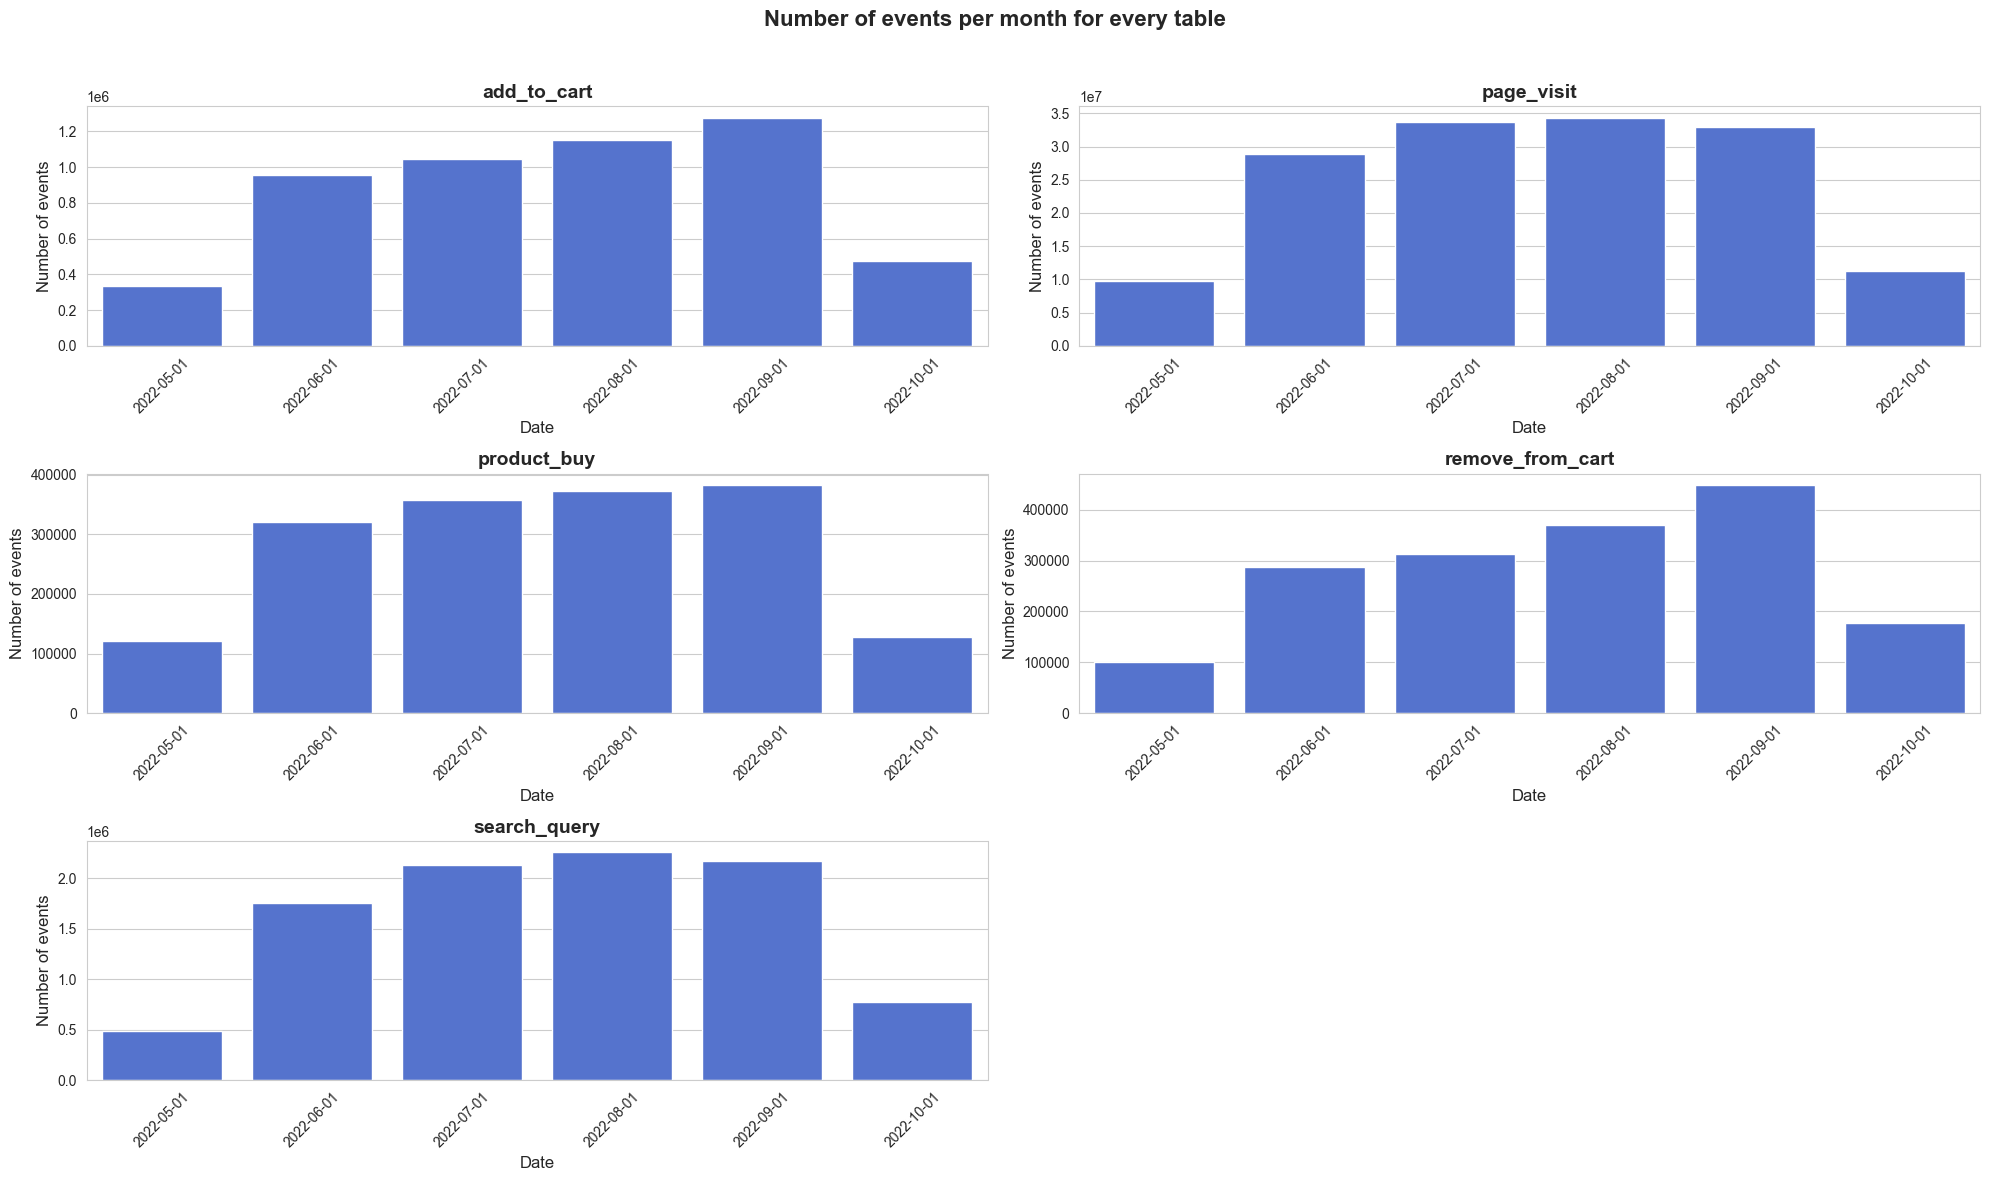

In [ ]:
plot_time_histograms(normalize=False)

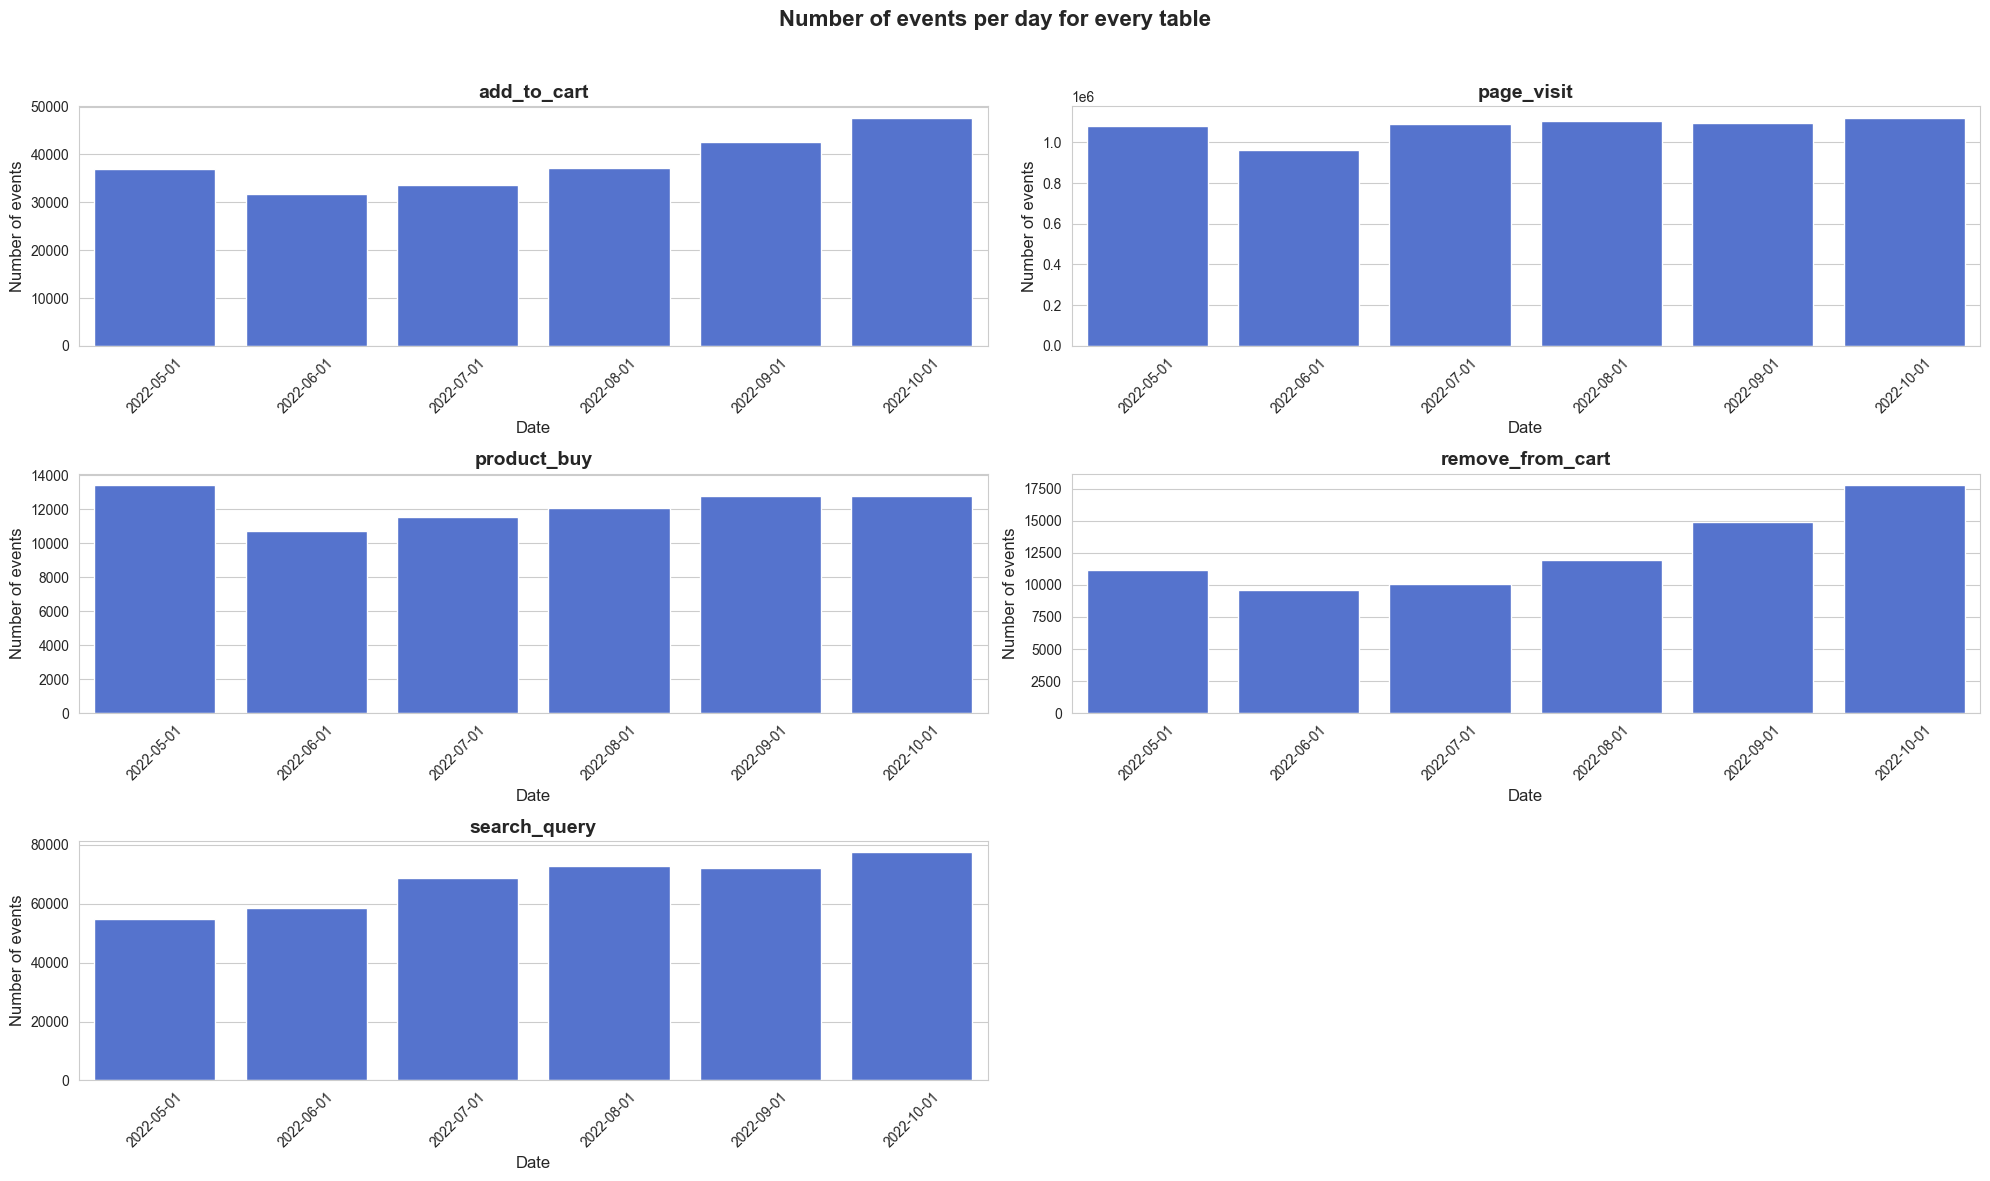

In [ ]:
plot_time_histograms(normalize=True)

In [ ]:
def plot_users_events_histogram():
    sns.set_style("whitegrid") 
    fig, axes = plt.subplots(5, 2, figsize=(20, 16))
    fig.suptitle("Number of Events per Client for Each Table", fontsize=16, fontweight="bold")

    axes = axes.flatten()

    for i, (key, df) in enumerate(data["events"].items()):
        i *= 2
        dataframe = df.group_by("client_id").agg(pl.len().alias("count"))
        dataframe_active = dataframe.filter(pl.col("client_id").is_in(relevant_users))
        dataframe = dataframe.collect()
        dataframe_active = dataframe_active.collect()


        sns.histplot(dataframe["count"], bins=20, ax=axes[i], color="royalblue")
        sns.histplot(dataframe_active["count"], bins=20, ax=axes[i+1], color="royalblue")
        for j in (i, i+1):
            if j % 2:
                title = f"{key} for active users"
            else:
                title = f"{key} for all users"
            axes[j].set_title(title, fontsize=14, fontweight="bold")
            axes[j].set_ylabel("Number of users", fontsize=12)
            axes[j].set_xlabel("Number of Events", fontsize=12)
            axes[j].set_yscale('log') 

    fig.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()


### Events per client
Another fortunate fact for us, the distributions of particular events don't change significantly comparing between users selected for predictions, and all users. 

Talking about the data itself, we should think about taking special actions regarding to outlier users. As expected, most of them buy up to a dozen or so items, but there are people with over 300 boughts. We can see similar outliers also in other tables and we will later examine if they are same customers.

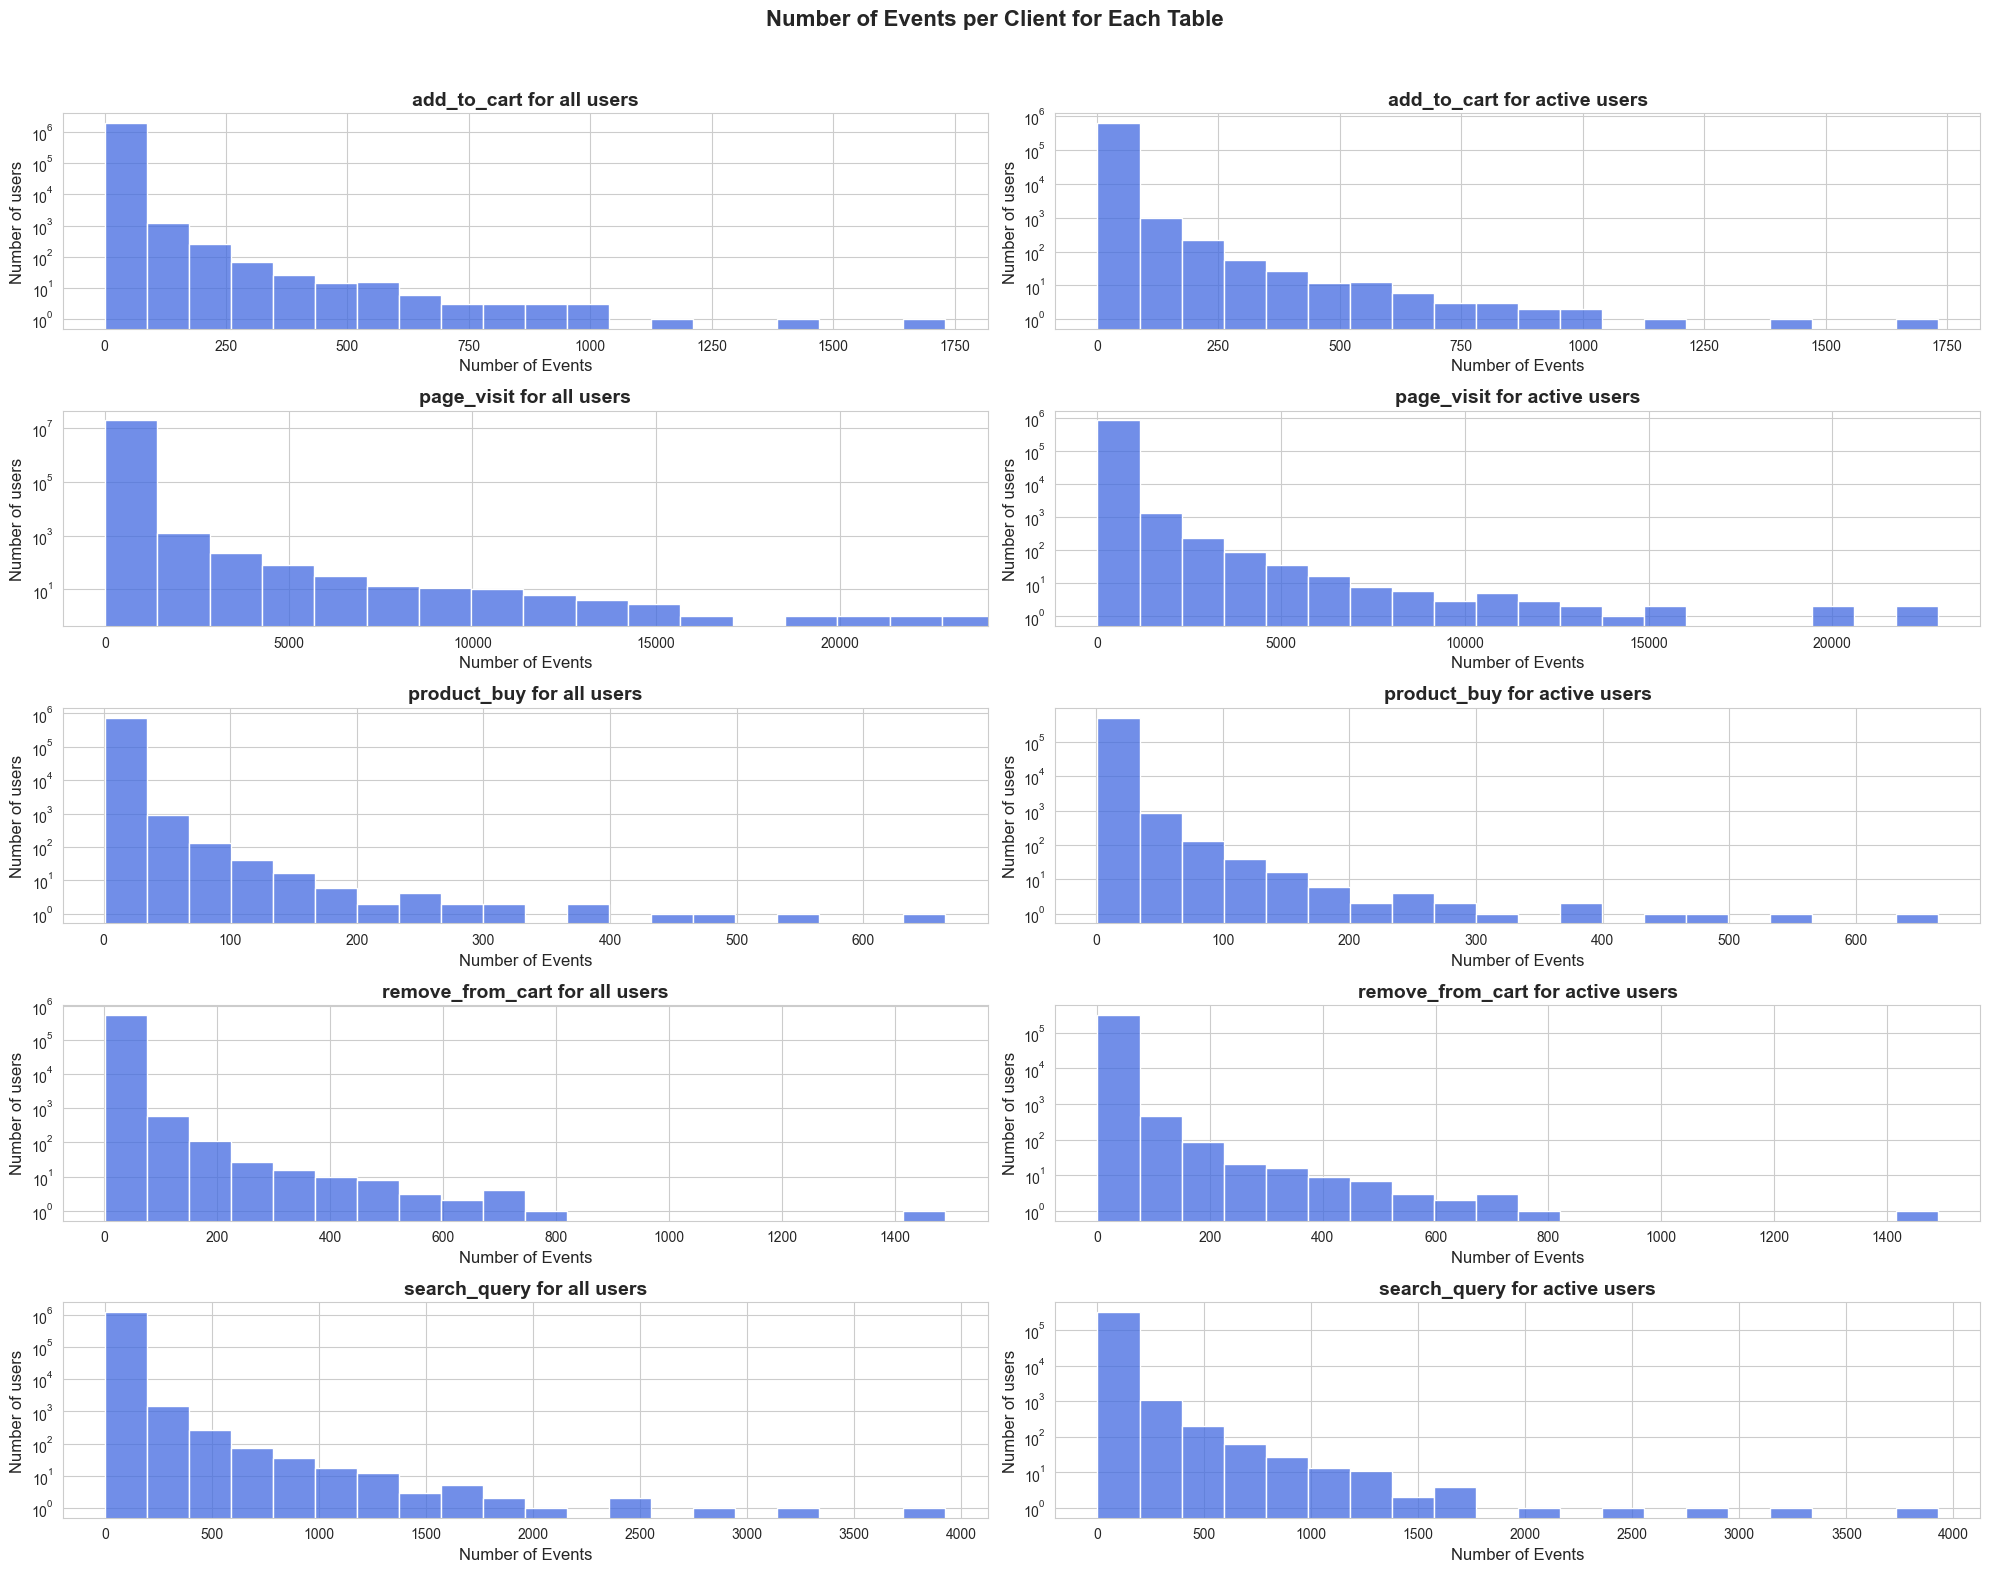

In [23]:
plot_users_events_histogram()


In the dataset, there are some outlier clients, whose behaviour seems completely unrealistic, maybe they are bots or some errors? For example, look at the client 4222553 who has over 27 thousands of page visits, but only 1 add to card action (bot?). One customer also has 313 boughts with only 1 page visit, which may be an error.

In [55]:
counts = unique_clients

for key, df in data["events"].items():
        df = df.group_by("client_id").agg(pl.len().alias(f"count_{key}"))
        counts = counts.join(on="client_id", other=df, how="left")

counts = counts.fill_null(0)
outliers = counts.filter((pl.col("count_add_to_cart") > 500) 
                         | (pl.col("count_page_visit") > 10000) 
                         | (pl.col("count_product_buy") > 300) 
                         | (pl.col("count_remove_from_cart") > 400) 
                         | (pl.col("count_search_query") > 1000)).collect()

with pl.Config(tbl_rows=1000): # Display all rows
    print(outliers)
outliers.write_csv("data/possible_outliers.csv")

shape: (97, 6)
┌───────────┬─────────────────┬─────────────────┬────────────────┬────────────────┬────────────────┐
│ client_id ┆ count_add_to_ca ┆ count_page_visi ┆ count_product_ ┆ count_remove_f ┆ count_search_q │
│ ---       ┆ rt              ┆ t               ┆ buy            ┆ rom_cart       ┆ uery           │
│ i64       ┆ ---             ┆ ---             ┆ ---            ┆ ---            ┆ ---            │
│           ┆ u32             ┆ u32             ┆ u32            ┆ u32            ┆ u32            │
╞═══════════╪═════════════════╪═════════════════╪════════════════╪════════════════╪════════════════╡
│ 71094     ┆ 967             ┆ 3823            ┆ 55             ┆ 711            ┆ 277            │
│ 322519    ┆ 505             ┆ 6577            ┆ 0              ┆ 111            ┆ 14             │
│ 1114847   ┆ 610             ┆ 5033            ┆ 58             ┆ 424            ┆ 235            │
│ 1150869   ┆ 454             ┆ 5277            ┆ 55             ┆ 361      

In [21]:
earliest_actions = unique_clients

for key, df in data["events"].items():
        df = df.group_by("client_id").agg(pl.col("timestamp").min().alias(f"min_{key}"))
        earliest_actions = earliest_actions.join(on="client_id", other=df, how="left")

earliest_actions = earliest_actions.drop_nulls()

In [22]:
earliest_action = earliest_actions.with_columns(
    min_date = pl.min_horizontal([pl.col(col) for col in earliest_actions.columns[1:]])
)

C:\Users\adams\AppData\Local\Temp\ipykernel_25664\785128633.py:2: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  min_date = pl.min_horizontal([pl.col(col) for col in earliest_actions.columns[1:]])


In [23]:
def plot_earliest_actions_histograms():
    sns.set_style("whitegrid")
    sns.set_palette("coolwarm")  
    
    fig, ax = plt.subplots(3, 2, figsize=(20, 12))
    fig.suptitle(
        "Number of users who performed their first action of every type on a given day",
        fontsize=16,
        fontweight="bold"
    )
    ax = ax.flatten()

    for i, col in enumerate(earliest_actions.columns[1:]):
        dataframe = earliest_actions.sort(col)
        grouped_df = dataframe.group_by_dynamic(col, every="1d").agg(pl.len().alias("len"))
        
        grouped_df = grouped_df.collect()

        sns.barplot(
            x=grouped_df[col], 
            y=grouped_df["len"], 
            ax=ax[i], 
            color="royalblue"
        )

        ax[i].set_title(col, fontsize=14, fontweight="bold")
        ax[i].set_xlabel("Date", fontsize=12)
        ax[i].set_ylabel("Number of users", fontsize=12)
        ax[i].tick_params(axis="x", rotation=45)

        xticks = ax[i].get_xticks()
        ax[i].set_xticks(xticks[::5])

    for j in range(i + 1, len(ax.flatten())):
        fig.delaxes(ax.flatten()[j])

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Looking at the plots with data containing first dates of every action and any action by an user, we know that the cold start may be a problem. Most users are active since the first day of the dataset, but many join throughout the time.

C:\Users\adams\AppData\Local\Temp\ipykernel_25664\2858888466.py:13: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for i, col in enumerate(earliest_actions.columns[1:]):


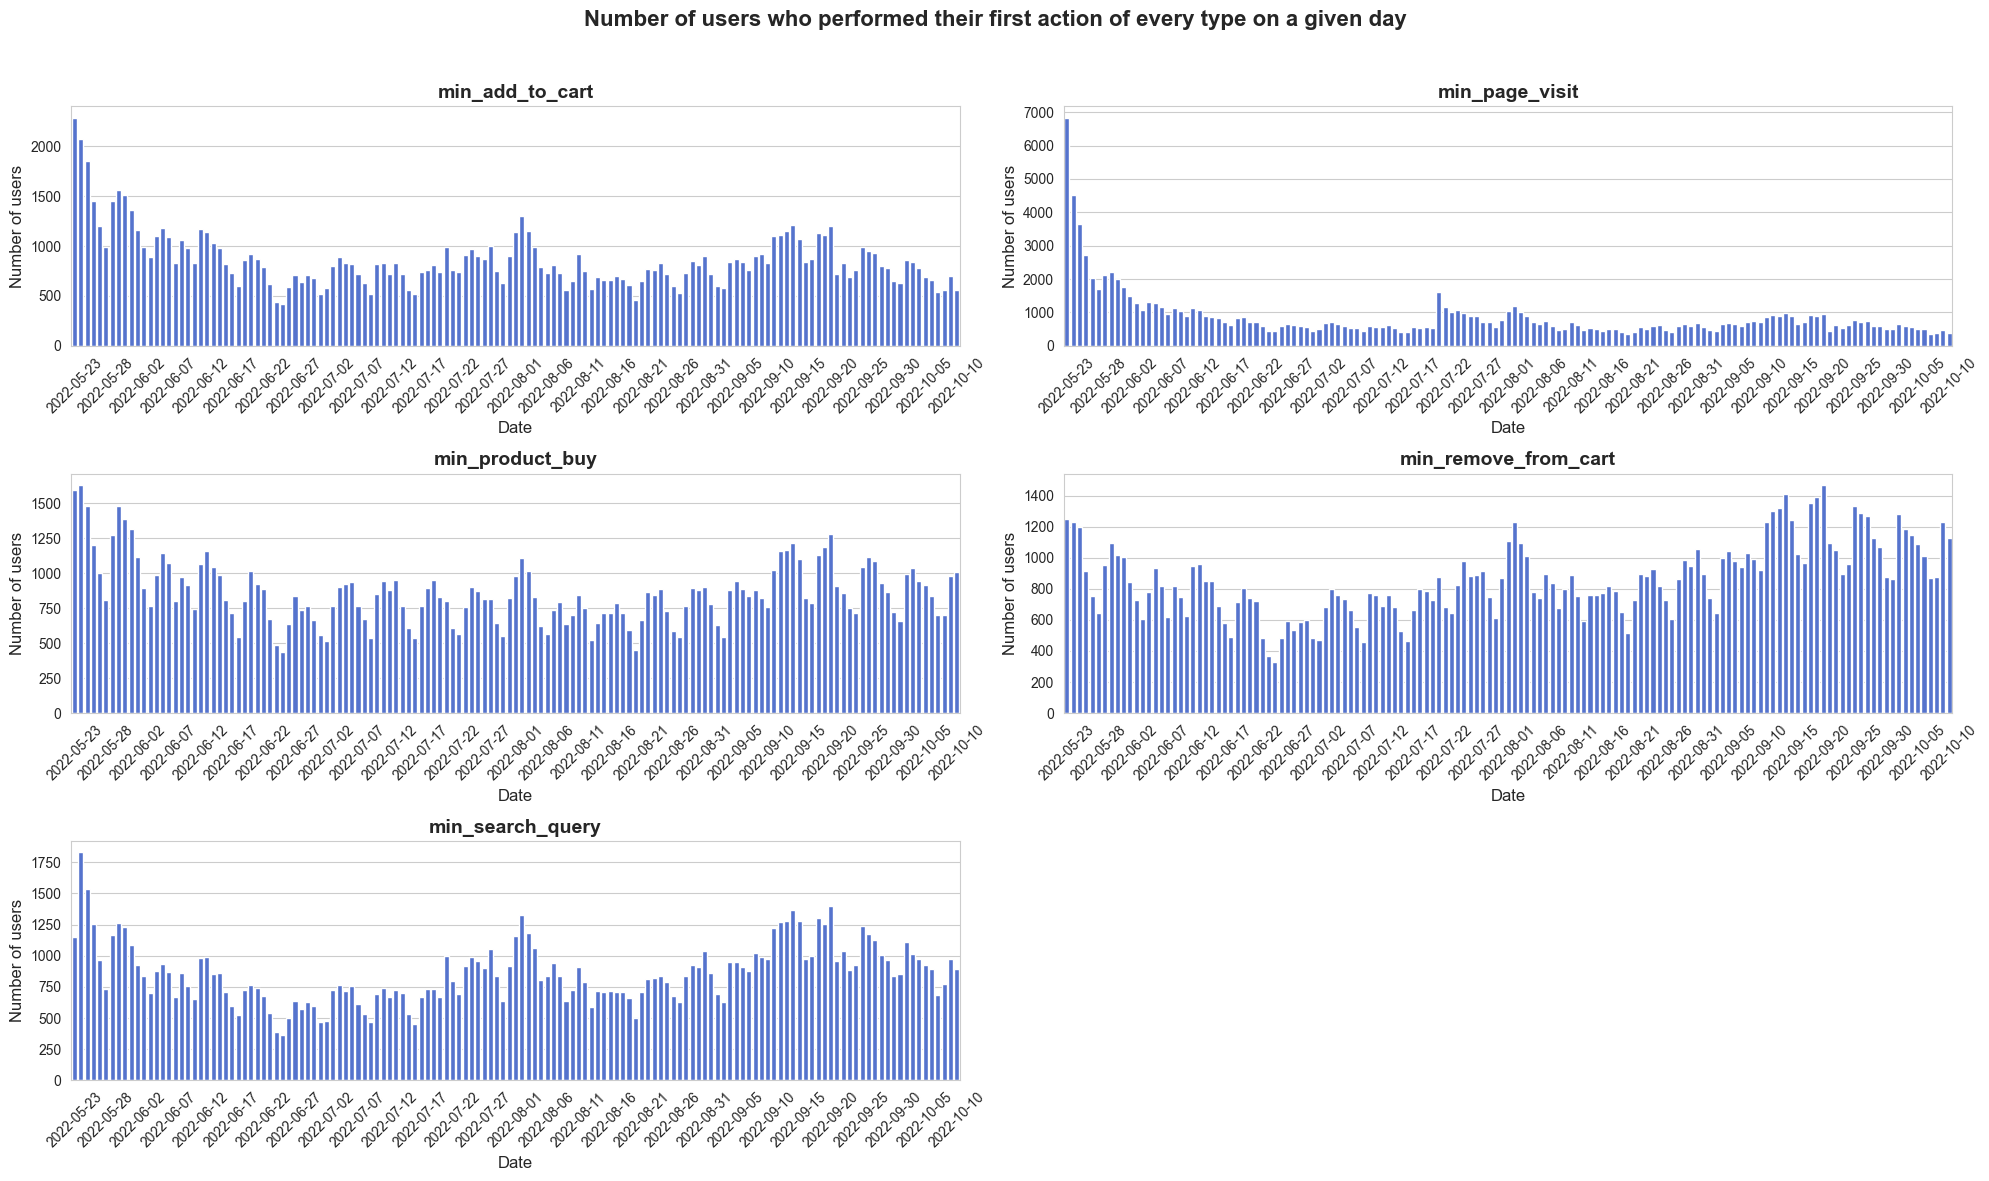

In [24]:
plot_earliest_actions_histograms()

In [25]:
def plot_earliest_action():
    sns.set_style("whitegrid")
    sns.set_palette("coolwarm")  

    dataframe = earliest_action.sort("min_date")
    grouped_df = dataframe.group_by_dynamic("min_date", every="1d").agg(pl.len().alias("len"))
        
    grouped_df = grouped_df.collect()

    fig = sns.barplot(
        x=grouped_df["min_date"], 
        y=grouped_df["len"], 
        color="royalblue"
    )

    fig.set_title("Number of users who performed their earliest action on the given day", fontsize=14, fontweight="bold")
    fig.set_xlabel("Date", fontsize=12)
    fig.set_ylabel("Number of users", fontsize=12)
    fig.tick_params(axis="x", rotation=45)
    xticks = fig.get_xticks()
    fig.set_xticks(xticks[::10])

    plt.show()

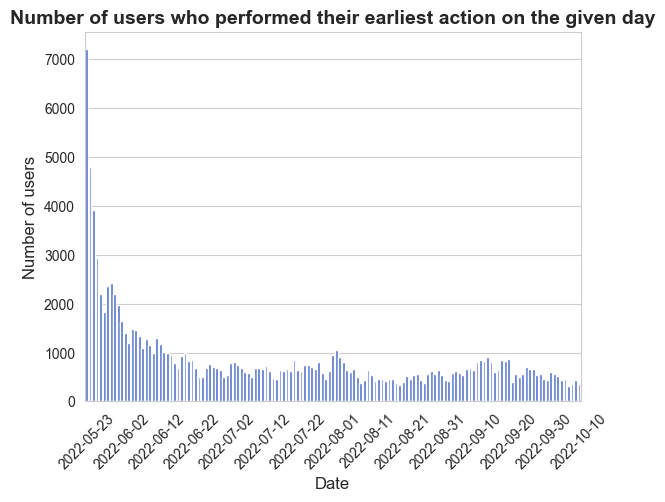

In [26]:
plot_earliest_action()